In [2]:
%load_ext zipline
# Necessary imports
import os
import zipline
from zipline.api import (order_target_percent, symbol, set_commission, set_slippage,
 schedule_function, date_rules, time_rules)
from pandas import Timestamp
from zipline.data.bundles import load
from zipline.api import order, record, symbol, get_open_orders
import pandas as pd
import zipline
import os
from pandas import Timestamp
from trading_calendars import get_calendar
from zipline.data.bundles import load
from zipline.api import order, record, symbol, set_benchmark
import zipline
import matplotlib.pyplot as plt
from datetime import datetime
from trading_calendars import get_calendar
#trading_calendar=get_calendar('24/7')
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
import talib as ta
import pytz
import pandas_datareader.data as web
from os import listdir
import numpy as np
from matplotlib import style

In [172]:
now = Timestamp.utcnow()
bundle = load('universe', os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))

print(symbols)

{'AVAX', 'ADA', 'MANA', 'FLOW', 'SOL', 'TFUEL', 'MATIC'}


In [2]:
!zipline ingest --bundle universe

[2022-04-15 04:00:37.143271] INFO: zipline.data.bundles.core: Ingesting universe.
Loading custom pricing data:   [------------------------------------]    0% | ADA: sid 0
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/zipline/data/bcolz_daily_bars.py:366: UserWarning: Ignoring 132 values because they are out of bounds for uint32:                 open      high       low     close      volume  dividend  ratio
date                                                                           
2021-01-06  0.258549  0.346298  0.256225  0.331898  6170988900       0.0      1
2021-01-07  0.332272  0.353344  0.283216  0.299980  5149188552       0.0      1
2021-01-08  0.300387  0.320191  0.266476  0.305597  4560690774       0.0      1
2021-01-11  0.304996  0.304996  0.233033  0.275466  4768803200       0.0      1
2021-01-16  0.302512  0.365411  0.302250  0.352444  4476161885       0.0      1
...              ...       ...       ...       ...         ...       ...    ...
2021-10-28  1.91224

Merging daily equity files:  [####################################]   


In [13]:
now = Timestamp.utcnow()
bundle = load('universe', os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))
symbols = list(symbols)
print('This is our universe. We trade among these ' + str(len(symbols)) + ' instruments.')
print(list(symbols))

This is our universe. We trade among these 7 instruments.
['ADA', 'SOL', 'TFUEL', 'MATIC', 'AVAX', 'FLOW', 'MANA']


In [9]:
def initialize(context):
    pass
def handle_data(context, data):
    slowma = data.history(symbol("SOL"), fields='price', bar_count=50, frequency='1d').mean()
    fastma = data.history(symbol("SOL"), fields='price', bar_count=10, frequency='1d').mean()
    if fastma < slowma:
        if symbol("SOL") not in get_open_orders():
            order_target_percent(symbol("SOL"), 0.04)

    if fastma > slowma:
        if symbol("SOL") not in get_open_orders():
            order_target_percent(symbol("SOL"), 0.96)

    record(SOL=data.current(symbol('SOL'), fields='price'))

In [10]:
start_date = pd.Timestamp('2020-01-05', tz='utc')
end_date = pd.Timestamp('2021-03-01', tz='utc')
# performance of algorithm once run
perf = zipline.run_algorithm(start=start_date,
                            end=end_date,
                            trading_calendar=get_calendar('24/7'),
                            initialize=initialize,
                            capital_base=100000,
                            handle_data=handle_data,
                            bundle='universe',
                            data_frequency='daily')

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


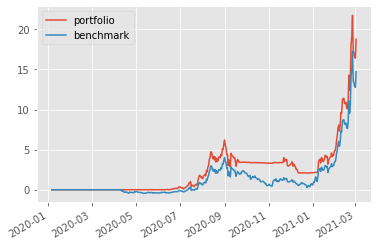

In [12]:
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.SOL.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)

plt.show()

### Description of strategy
Let’s define our trading strategy:
- Our stock universe consists of 7 stocks.
- The maximum portfolio size is kept at 30 so we have zero to thirty stocks in our portfolio at any given time.
- We are going to rebalance only on a monthly basis to avoid excessive trading and associated cost.
- There is a trading fee of 0.4%.
- We will use 14 periods of RSI to define our buy and sell logic. We will calculate the RSI of these 7 stocks every month and create a ranking table. If the RSI is less than 30 for a stock and we are not already holding it then it is in our buy list. If the stock has an RSI of more than 70 and we are holding it, we exit the position. We keep the maximum portfolio size at not more than 30 stocks.
- We do the position allocation based on the mean of 20 days rolling standard deviation for 126 days time period. This ensures the position allocation is based on risk parity, meaning the stock will have weights based on equal risk, less the volatility of stock more the weightage.
### Description of python code
- We do the necessary imports of python libraries. 
- Define the testing date ranges and convert the time zone to UTC.
- Read all csv files in the data/data folder and create a list of 7 tickers.
- Define model parameters including initial portfolio size, the upper and lower limit of RSI, RSI period, a rolling window for standard deviation, maximum portfolio size, commission, and slippage parameters.
- The function compute_rsi calculates the 14 days RSI and returns the last element of the time series. I have used python library ta-lib for this however you can choose any suitable library for this job. Few other options include ta or finta.
- In the volatility function, we take a 126-day time series of closing prices, calculate the daily returns, and take a mean of 20 days rolling window of standards deviation.
- The function output_progress is just to track the progress output and display monthly returns during backtest execution.
- We initialize the commission, slippage, and tickers in the function initialize and schedule the rebalancing on a monthly basis.
- The function rebalance is the core of our strategy and I will describe it in detail in the next couple of points. First, we call output_progress to display monthly progress during backtesting. Then we get zipline symbol for each ticker. Next, we fetch historical daily closing pricing for 126 time periods.
- Next, we invoke compute_rsi function by passing historically closing pricing time series for each ticker and create a ranking table of ticker and corresponding RSI value in ascending order.
- Now, let’s work on the selling logic first. We get the existing portfolio ticker list using the variable kept_positions. Then, for each existing security in the portfolio, we check if it is part of our universe, if not we order the target percentage to zero and remove the security from the variable kept_positions. Then, in elif we check if the RSI value of the security is more than the upper bound if so we exit the position and set the target percentage to zero.
- We will move to our ticker selection logic. We identify the number of stocks to replace by the difference between maximum portfolio size and the length of the variable kept_positions. Now, we create a buy list without including stocks in the variable kept_positions. Then, from this buy list, we take a number of securities equal to replacement length where the RSI is less than the lower threshold.
- Finally, we make a new portfolio by joining the buy list with securities in the variable kept_positions.
- Let’s discuss the position allocation now. We can have multiple options to use such as 1/n (equal weights), efficient frontier optimization, or equal risk parity. I have used 1/n option in my previous post — Momentum Strategy using Backtrader with BSE 500 as Stocks Universe and got very good results. We will keep the efficient frontier optimization for some other day and for now go with equal risk parity. That means the weight of each security will be in accordance with its risk which is measured using standard deviation. Higher the risk lower the weight. We calculate the volatility table by taking a mean of 20 days rolling standard deviation for 126 days time period for each security in the new portfolio table. To get the individual security weight, we take the inverse of the volatility table and divide it by the sum of the inverse table.
- Almost done with rebalancing logic, we have the new portfolio of securities and corresponding weights. We iterate all the items in the new portfolio and if the security is in the kept position list or if the RSI is lower than the threshold, we order the target percentage.
- In the function analyze we just calculate the annualized returns and print it along with maximum drawdown.
- Finally, its time to run the algorithm with our earlier defined date range, initial capital, and bundle as your custom bundle.

In [117]:
    
    
    
    
    slowma = data.history(symbol("SOL"), fields='price', bar_count=50, frequency='1d').mean()
    fastma = data.history(symbol("SOL"), fields='price', bar_count=10, frequency='1d').mean()
    if fastma < slowma:
        if symbol("SOL") not in get_open_orders():
            order_target_percent(symbol("SOL"), 0.04)
            order_target_percent(symbol("ADA"), 0.04)      
    print(hist)
    if fastma > slowma:
        if symbol("SOL") not in get_open_orders():
            order_target_percent(symbol("SOL"), 0.96)

NameError: name 'data' is not defined

In [187]:
# for dataframe slicing operations
idx = pd.IndexSlice
# Testing date range
start = pd.Timestamp('2021-01-05', tz='utc')
end = pd.Timestamp('2022-01-05', tz='utc')
# Commission and Slippage Parameters
enable_commission = True
commission_pct = 0.004
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05
TICKERS = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']

In [194]:
# function to calculate RSI
def compute_rsi(close):
    rsi = ta.RSI(close.values, timeperiod=rsi_period)
    return rsi[-1]
# function to calculate volatility
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().mean()
    return std
def initialize(context):
    context.universe  = ['SOL', 'TFUEL', 'MATIC', 'FLOW', 'MANA', 'ADA', 'AVAX']
    context.upper = 70
    context.lower = 30
    context.rsi_period = 14
    context.vola_window = 20
     # Used only for progress output.
    context.last_month = intial_portfolio   
    # Fetch and store index tickers
    context.index_members = TICKERS
def handle_data(context, data):
    # Write progress output during the backtest
    output_progress(context)
    
     # Finally, get the Zipline symbols for the tickers
    coins =   [symbol(ticker) for ticker in context.universe]
    
    # Get historical data for volatility calculation
    hist = data.history(coins, "close", 20, "1d")
    hist = hist.dropna()
    
     # Make momentum ranking table based on RSI
    ranking_table = hist.apply(compute_rsi)
    ranking_table = ranking_table.sort_values(ascending=True)
    ranking_table.to_csv('ranking/ranking_table.csv')
    
    # Sell Logic
    # First we check if any existing position should be sold.
    # Sell if stock has RSI greater than upper value.
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
        elif ranking_table[security] > upper:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)


    record(SOL=data.current(symbol('SOL'), 'price'),
           TFUEL=data.current(symbol('TFUEL'), 'price'),
           MATIC=data.current(symbol('MATIC'), 'price'),
           FLOW=data.current(symbol('FLOW'), 'price'),
           MANA=data.current(symbol('MANA'), 'price'),
            ADA=data.current(symbol('ADA'), 'price'),
            AVAX=data.current(symbol('AVAX'), 'price'),
          )

In [195]:
start = pd.Timestamp('2021-05-05', tz='utc')
end = pd.Timestamp('2022-01-05', tz='utc')
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
   # analyze=analyze, 
    capital_base=intial_portfolio, 
    handle_data = handle_data,
    data_frequency = 'daily', 
    bundle= 'universe')

2021-05-05 - Last Month Result: 0.00%
2021-05-06 - Last Month Result: 0.00%
2021-05-07 - Last Month Result: 0.00%
2021-05-10 - Last Month Result: 0.00%
2021-05-11 - Last Month Result: 0.00%
2021-05-12 - Last Month Result: 0.00%
2021-05-13 - Last Month Result: 0.00%
2021-05-14 - Last Month Result: 0.00%
2021-05-17 - Last Month Result: 0.00%
2021-05-18 - Last Month Result: 0.00%
2021-05-19 - Last Month Result: 0.00%
2021-05-20 - Last Month Result: 0.00%
2021-05-21 - Last Month Result: 0.00%
2021-05-24 - Last Month Result: 0.00%
2021-05-25 - Last Month Result: 0.00%
2021-05-26 - Last Month Result: 0.00%
2021-05-27 - Last Month Result: 0.00%
2021-05-28 - Last Month Result: 0.00%
2021-06-01 - Last Month Result: 0.00%
2021-06-02 - Last Month Result: 0.00%
2021-06-03 - Last Month Result: 0.00%
2021-06-04 - Last Month Result: 0.00%
2021-06-07 - Last Month Result: 0.00%
2021-06-08 - Last Month Result: 0.00%
2021-06-09 - Last Month Result: 0.00%
2021-06-10 - Last Month Result: 0.00%
2021-06-11 -

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710:

2021-08-09 - Last Month Result: 0.00%
2021-08-10 - Last Month Result: 0.00%
2021-08-11 - Last Month Result: 0.00%
2021-08-12 - Last Month Result: 0.00%
2021-08-13 - Last Month Result: 0.00%
2021-08-16 - Last Month Result: 0.00%
2021-08-17 - Last Month Result: 0.00%
2021-08-18 - Last Month Result: 0.00%
2021-08-19 - Last Month Result: 0.00%
2021-08-20 - Last Month Result: 0.00%
2021-08-23 - Last Month Result: 0.00%
2021-08-24 - Last Month Result: 0.00%
2021-08-25 - Last Month Result: 0.00%
2021-08-26 - Last Month Result: 0.00%
2021-08-27 - Last Month Result: 0.00%
2021-08-30 - Last Month Result: 0.00%
2021-08-31 - Last Month Result: 0.00%
2021-09-01 - Last Month Result: 0.00%
2021-09-02 - Last Month Result: 0.00%
2021-09-03 - Last Month Result: 0.00%
2021-09-07 - Last Month Result: 0.00%
2021-09-08 - Last Month Result: 0.00%
2021-09-09 - Last Month Result: 0.00%
2021-09-10 - Last Month Result: 0.00%
2021-09-13 - Last Month Result: 0.00%
2021-09-14 - Last Month Result: 0.00%
2021-09-15 -

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710:

2021-11-12 - Last Month Result: 0.00%
2021-11-15 - Last Month Result: 0.00%
2021-11-16 - Last Month Result: 0.00%
2021-11-17 - Last Month Result: 0.00%
2021-11-18 - Last Month Result: 0.00%
2021-11-19 - Last Month Result: 0.00%
2021-11-22 - Last Month Result: 0.00%
2021-11-23 - Last Month Result: 0.00%
2021-11-24 - Last Month Result: 0.00%
2021-11-26 - Last Month Result: 0.00%
2021-11-29 - Last Month Result: 0.00%
2021-11-30 - Last Month Result: 0.00%
2021-12-01 - Last Month Result: 0.00%
2021-12-02 - Last Month Result: 0.00%
2021-12-03 - Last Month Result: 0.00%
2021-12-06 - Last Month Result: 0.00%
2021-12-07 - Last Month Result: 0.00%
2021-12-08 - Last Month Result: 0.00%
2021-12-09 - Last Month Result: 0.00%
2021-12-10 - Last Month Result: 0.00%
2021-12-13 - Last Month Result: 0.00%
2021-12-14 - Last Month Result: 0.00%
2021-12-15 - Last Month Result: 0.00%
2021-12-16 - Last Month Result: 0.00%
2021-12-17 - Last Month Result: 0.00%
2021-12-20 - Last Month Result: 0.00%
2021-12-21 -

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710:

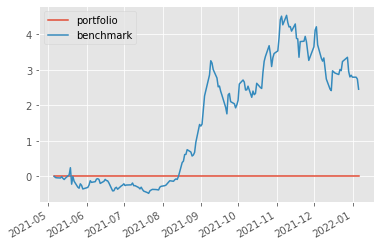

In [193]:
style.use("ggplot")
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.SOL.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)
plt.show()

In [19]:
# for dataframe slicing operations
idx = pd.IndexSlice
# Define Model Parameters
intial_portfolio = 500000
upper = 70
lower = 30
rsi_period = 14
vola_window = 20
mportfolio_size = 3

# Commission and Slippage Parameters
enable_commission = True
commission_pct = 0.004
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05

# function to calculate RSI
def compute_rsi(close):
    rsi = ta.RSI(close.values, timeperiod=rsi_period)
    return rsi[-1]

# function to calculate volatility
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().mean()
    return std

# output performance
def output_progress(context):
    # Output performance numbers during backtest run on monthly basis
    # Get today's date
    today = zipline.api.get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

# Initialization the trading logic
def initialize(context):
   
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)   
    set_slippage(slippage_model)    
    
    # Used only for progress output.
    context.last_month = intial_portfolio
    
    # Fetch and store index tickers
    context.index_members = TICKERS
    
    #Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

def rebalance(context, data):
    # Write progress output during the backtest
    output_progress(context)
    
    # Finally, get the Zipline symbols for the tickers
    universe = [symbol(ticker) for ticker in context.index_members]
    
    # Get historical data for volatility calculation
    hist = data.history(universe, "close", 126, "1d")
    hist = hist.dropna()
    
    # Make momentum ranking table based on RSI
    ranking_table = hist.apply(compute_rsi).sort_values(ascending=True)
    ranking_table.to_csv('data/ranking_table.csv')

    # Sell Logic
    # First we check if any existing position should be sold.
    # Sell if stock has RSI greater than upper value.
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
        elif ranking_table[security] > upper:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
    
    # Stock Selection Logic
    # Check how many stocks we are keeping from last month.
    # Take the desired number of stock from the ranking table where RSI is less than lower.
    replacement_stocks = mportfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[~ranking_table.index.isin(kept_positions)]
    buy_list = buy_list[buy_list.loc[buy_list.index] < lower].dropna()[:replacement_stocks]    
    new_portfolio = pd.concat((buy_list,ranking_table.loc[ranking_table.index.isin(kept_positions)]))

    # Calculate inverse volatility for stocks,and make target position weights.
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    
    # Rebalance the tickers based on new weights
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] < lower:
                order_target_percent(security, weight)

def analyze(context, perf):
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))
    return

perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
   # analyze=analyze, 
    capital_base=intial_portfolio, 
   # handle_data = rebalance,
    data_frequency = 'daily', 
    bundle= 'universe')


2021-02-01 - Last Month Result: 0.00%
2021-03-01 - Last Month Result: 0.00%
2021-04-01 - Last Month Result: 0.00%
2021-05-03 - Last Month Result: 0.00%
2021-06-01 - Last Month Result: 0.00%
2021-07-01 - Last Month Result: 0.00%
2021-08-02 - Last Month Result: 0.00%
2021-09-01 - Last Month Result: 0.00%
2021-10-01 - Last Month Result: 0.00%
2021-11-01 - Last Month Result: 0.00%
2021-12-01 - Last Month Result: 0.00%
2022-01-03 - Last Month Result: 0.00%


/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/empyrical/stats.py:710: